### Phase 2 - EDA
----
DS5220 Supervised Machine Learning  
Fall 2024   
Instructor: Steve Morin PhD  
Nelson Farrell and Michael Massone    

-----
#### III. Explore the Data
1. Create a copy of the data for exploration.
2. Create a dedicated Jupyter notebook to keep a record of your data exploration.
3. Identify the target attribute.
4. Study each attribute and its characteristics.
    - The goal here is to prepare for setting the attribute configuration for machine learning.
    - We are looking for each attribute's role in supervised machine learning. 
    - Possible roles are:  
        • attributes with missingness above threshold  
        • non machine learning attributes  
        • attributes to exclude from machine learning      
5. Visualizations as needed.
6. Study the correlations and associations between attributes and between attributes and target.
    - This might inform your attribute configuration.
7. Study how you would solve the problem manually.
8. Identify additional data that would be useful (go back to “Get the Data”).
    - You are not required to get the additional data.
    - You should give this some thought and document what data might add to your project.

In [15]:
# Libraries
import os
import sys
from time import time
from pathlib import Path
from nbconvert import HTMLExporter
import nbformat

import missingno as msno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
from scipy.stats import zscore

In [16]:
# Set Working Dir
path = Path.cwd()
path_to_project_directory = path.parent
sys.path.insert(1, str(path_to_project_directory))
print(f"The working directory has been set to: {str(path_to_project_directory)}")


The working directory has been set to: /Users/mikey/Library/Mobile Documents/com~apple~CloudDocs/Code/roux_class_files/DS5220/final_project/customer-segmentation


In [17]:
# Modules
from modules.phase1_utils import * 


In [18]:
# Script runtime
start = time()

In [19]:
# Params

# Paths to Data
train_path = "data/data_splits/train_df.csv"

target = "Segmentation"

random_state = 18


In [20]:
# Utility Functions
def separate_unique_columns(df):
    """
    This function separates columns of a DataFrame into those with 100% unique values and those with less than 100% unique values.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.

    Returns:
    dict: A dictionary with two keys: '100% unique' and '<100% unique'. Each contains a list of column names.
    """
    unique_cols = []
    non_unique_cols = []

    for column in df.columns:
        num_unique = df[column].nunique()
        total_values = df[column].size
        
        if num_unique == total_values:
            unique_cols.append(column)
        else:
            non_unique_cols.append(column)
    
    print("*****************************")
    print("non_ML_attr")
    for attr in unique_cols:
        print(attr)
    print("*****************************")
    print("ML_attr")
    for attr in non_unique_cols:
        print(attr)

    return {
        'non_ML_attr': unique_cols,
        'ML_attr': non_unique_cols
    }

def check_column_types_and_nans(df, threshold=0.2):
    '''
    Checks each column of a dataframe and returns a list of numerical attributes and nominal attributes, 
    along with NaN counts for each column
    
    Inputs:
        df(pd.DataFrame): Dataframe to be checked.
        threhsold(float): NAN ratio threshold to add cols to exclusion list. Default is 0.20.
    Out:
        dict{
            'numerical_cols': numerical_cols,     
            'nominal_cols': non_numerical_cols,       
            }
    '''
    
    numerical_cols = []
    num_nan_count = []
    non_numerical_cols = []
    nom_nan_count = []
    nan_above_thresold = []
    
    # Iterate through each column in the DataFrame
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            numerical_cols.append(col)
            nan_count = df[col].isna().sum()
            num_nan_count.append(nan_count) # Count NaN values for the column
            nan_above_thresold.append(col) if nan_count/df.shape[0] > threshold else None
        else:
            non_numerical_cols.append(col)
            nan_count = df[col].isna().sum()
            nom_nan_count.append(nan_count)  
            nan_above_thresold.append(col) if nan_count/df.shape[0] > threshold else None

    
    # Print out the results with Dtype and NaN counts
    print("*"*50)
    print("Numerical Columns:")
    if not numerical_cols:
        print("**NONE**")
    else:    
        for col, nan_count in zip(numerical_cols, num_nan_count):
            print(f"{col} \n - dtype: {df[col].dtype} \n - NaN count: {nan_count} \n - NaN ratio: {nan_count/df.shape[0]}")
    
    print("*"*50)    
    print("Non-Numerical Columns:")
    if not non_numerical_cols:
        print("**NONE**")
    else:
        for col, nan_count in zip(non_numerical_cols, nom_nan_count):
            print(f"{col} \n - dtype: {df[col].dtype} \n - NaN count: {nan_count} \n - NaN ratio: {nan_count/df.shape[0]}")

    print("*"*50)
    print(f"Columns with NAN ration greather than {threshold * 100}%:")
    if not nan_above_thresold:
        print("**NONE**")
    else:
        for col in nan_above_thresold:
            print(col)
            
    return {'numerical_cols': numerical_cols, 'nominal_cols': non_numerical_cols, 'nan_above_threshold': nan_above_thresold}


In [21]:
# Import data
train_df = pd.read_csv(str( path_to_project_directory /train_path))
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            6454 non-null   int64  
 1   ID               6454 non-null   int64  
 2   Gender           6454 non-null   object 
 3   Ever_Married     6343 non-null   object 
 4   Age              6454 non-null   int64  
 5   Graduated        6395 non-null   object 
 6   Profession       6348 non-null   object 
 7   Work_Experience  5808 non-null   float64
 8   Spending_Score   6454 non-null   object 
 9   Family_Size      6190 non-null   float64
 10  Var_1            6394 non-null   object 
 11  Segmentation     6454 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 605.2+ KB


In [8]:
col_info_dict = check_column_types_and_nans(train_df)

**************************************************
Numerical Columns:
index 
 - dtype: int64 
 - NaN count: 0 
 - NaN ratio: 0.0
ID 
 - dtype: int64 
 - NaN count: 0 
 - NaN ratio: 0.0
Age 
 - dtype: int64 
 - NaN count: 0 
 - NaN ratio: 0.0
Work_Experience 
 - dtype: float64 
 - NaN count: 646 
 - NaN ratio: 0.10009296560272699
Family_Size 
 - dtype: float64 
 - NaN count: 264 
 - NaN ratio: 0.040904865199876045
**************************************************
Non-Numerical Columns:
Gender 
 - dtype: object 
 - NaN count: 0 
 - NaN ratio: 0.0
Ever_Married 
 - dtype: object 
 - NaN count: 111 
 - NaN ratio: 0.017198636504493336
Graduated 
 - dtype: object 
 - NaN count: 59 
 - NaN ratio: 0.00914161760148745
Profession 
 - dtype: object 
 - NaN count: 106 
 - NaN ratio: 0.01642392314843508
Spending_Score 
 - dtype: object 
 - NaN count: 0 
 - NaN ratio: 0.0
Var_1 
 - dtype: object 
 - NaN count: 60 
 - NaN ratio: 0.009296560272699102
Segmentation 
 - dtype: object 
 - NaN count: 0 
 -

In [9]:
col_info_dict

{'numerical_cols': ['index', 'ID', 'Age', 'Work_Experience', 'Family_Size'],
 'nominal_cols': ['Gender',
  'Ever_Married',
  'Graduated',
  'Profession',
  'Spending_Score',
  'Var_1',
  'Segmentation'],
 'nan_above_threshold': []}

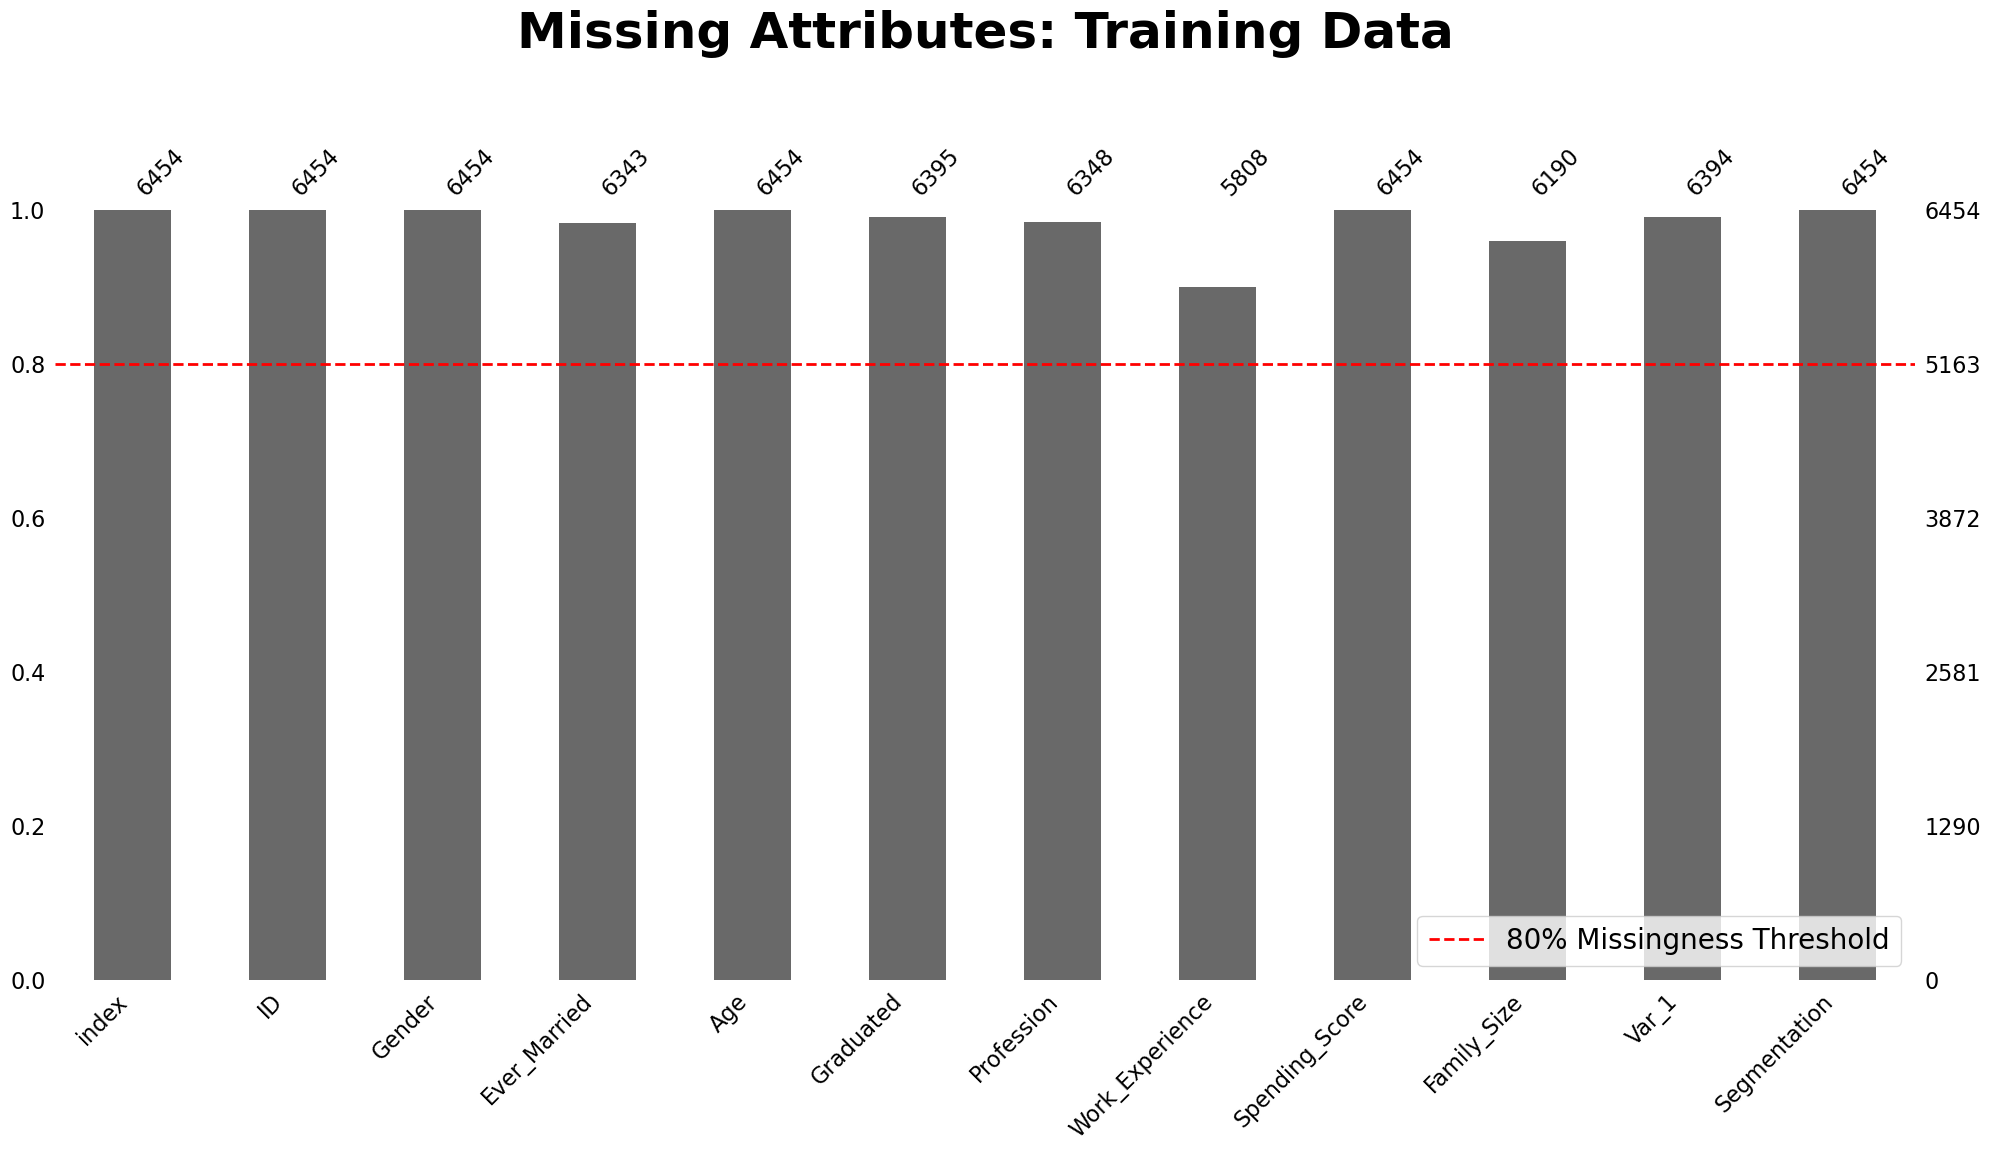

In [10]:
msno.bar(train_df)
plt.title("Missing Attributes: Training Data", fontsize = 36, weight = 'bold', y = 1.2)
plt.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label="80% Missingness Threshold")
plt.legend(loc='lower right', fontsize=20)
plt.show()

In [11]:
ml_attr_dict = separate_unique_columns(train_df)

*****************************
non_ML_attr
index
ID
*****************************
ML_attr
Gender
Ever_Married
Age
Graduated
Profession
Work_Experience
Spending_Score
Family_Size
Var_1
Segmentation


In [12]:
ml_attr_dict

{'non_ML_attr': ['index', 'ID'],
 'ML_attr': ['Gender',
  'Ever_Married',
  'Age',
  'Graduated',
  'Profession',
  'Work_Experience',
  'Spending_Score',
  'Family_Size',
  'Var_1',
  'Segmentation']}

In [13]:
# seperate numerical machine learning attributes
numerical_df = train_df[[col for col in col_info_dict['numerical_cols'] if col not in ml_attr_dict['non_ML_attr']]].copy()
numerical_df.info()

numerical_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              6454 non-null   int64  
 1   Work_Experience  5808 non-null   float64
 2   Family_Size      6190 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 151.4 KB


Age  Work_Experience  Family_Size
0   32              9.0          1.0
1   72              NaN          2.0
2   33              1.0          4.0
3   48              0.0          6.0
4   28              9.0          1.0
5   45              3.0          3.0
6   43              0.0          1.0
7   28              1.0          3.0
8   38              4.0          1.0
9   33              7.0          5.0

____________________________________________________________________________________________________
Attribute: Age
____________________________________________________________________________________________________
count    6454.000000
mean       43.592036
std        16.672806
min        18.000000
25%        31.000000
50%        41.000000
75%        53.000000
max        89.000000
Name: Age, dtype: float64

Outliers in Age:
None


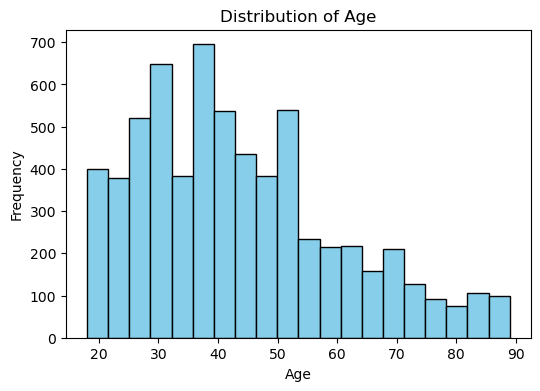

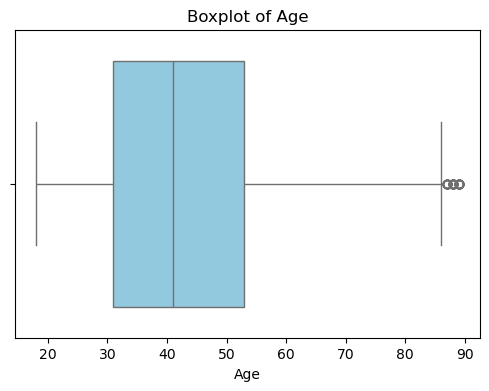

____________________________________________________________________________________________________
Attribute: Work_Experience
____________________________________________________________________________________________________
count    5808.000000
mean        2.671488
std         3.434175
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        14.000000
Name: Work_Experience, dtype: float64

Outliers in Work_Experience:
None


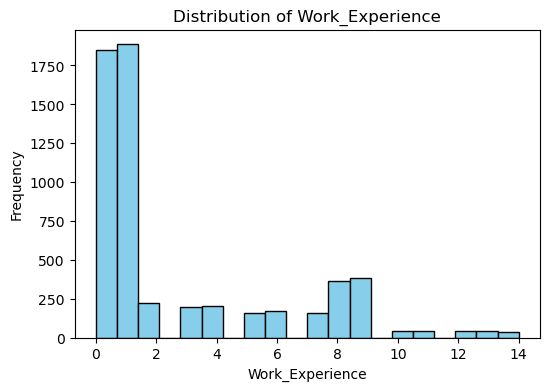

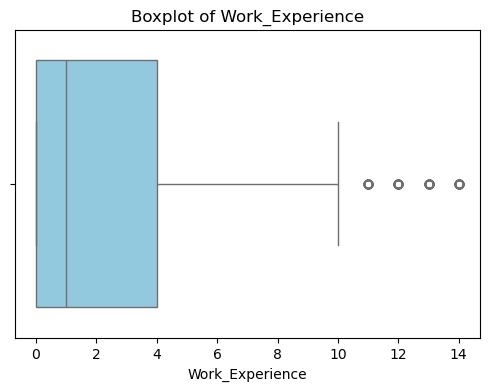

____________________________________________________________________________________________________
Attribute: Family_Size
____________________________________________________________________________________________________
count    6190.000000
mean        2.839742
std         1.531119
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         9.000000
Name: Family_Size, dtype: float64

Outliers in Family_Size:
None


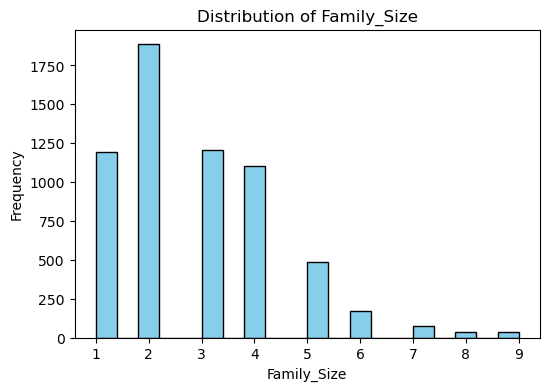

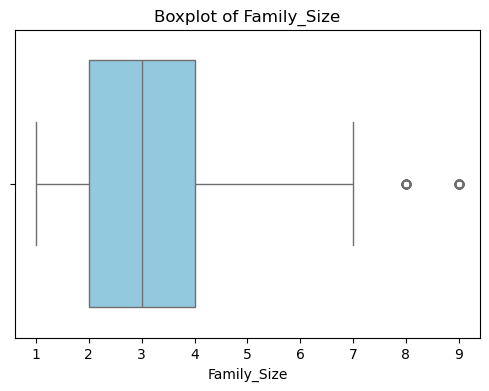

In [14]:
# numerical EDA

def plot_histogram(df, column, bins=20):
    plt.figure(figsize=(6, 4))
    plt.hist(df[column], bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

def plot_boxplot(df, column):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column], color='skyblue')
    plt.title(f'Boxplot of {column}')
    plt.show()

def detect_outliers_zscore(df, column):
    z_scores = zscore(df[column])
    outliers = df[column][(z_scores > 3) | (z_scores < -3)]
    print(f'\nOutliers in {column}:\n{None if not list(outliers) else outliers}')

for col in numerical_df.columns:
    print(("_"*100))
    print(f'Attribute: {col}')
    if col == target:
            print("******TARGET******")
    print(("_"*100))
    print(numerical_df[col].describe())
    detect_outliers_zscore(numerical_df, col)
    plot_histogram(numerical_df, col)
    plot_boxplot(numerical_df, col)
    


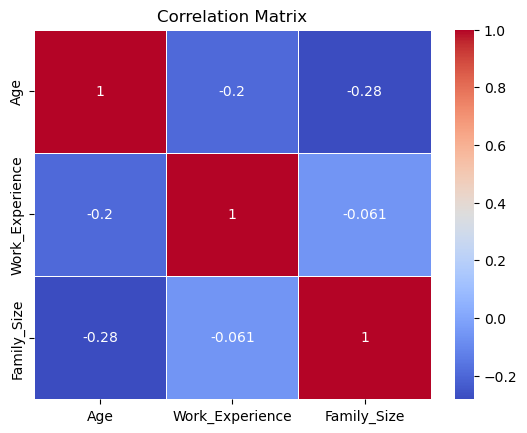

In [15]:
# Correlation
def plot_correlation_matrix(df):
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

plot_correlation_matrix(numerical_df)

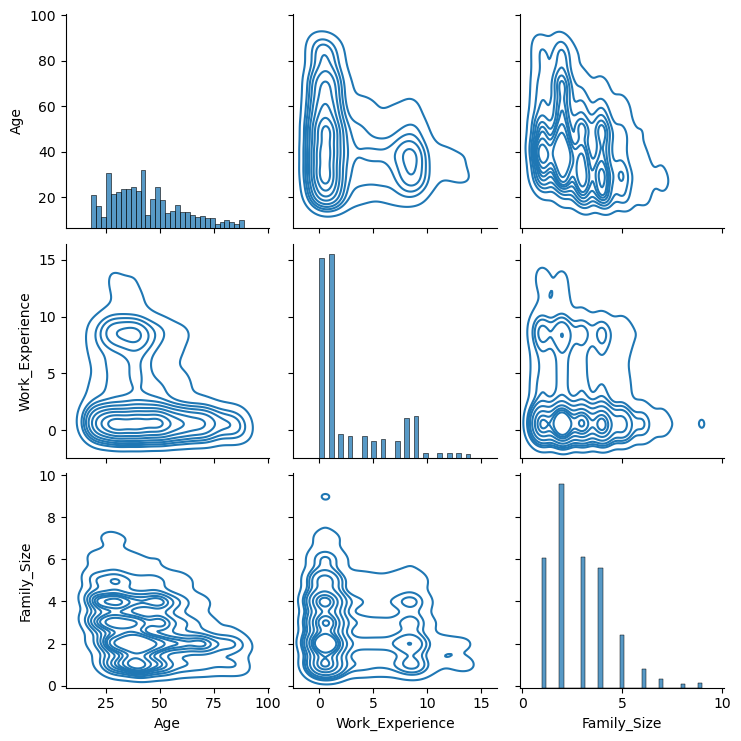

In [16]:
# Pairplots
def plot_pairplot(df):
    sns.pairplot(df, diag_kind="hist", kind="kde")
    plt.show()

plot_pairplot(numerical_df)

In [17]:
# seperate nominal machine learning attributes
nominal_df = train_df[[col for col in col_info_dict['nominal_cols'] if col not in ml_attr_dict['non_ML_attr']]].copy()
nominal_df.info()

nominal_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          6454 non-null   object
 1   Ever_Married    6343 non-null   object
 2   Graduated       6395 non-null   object
 3   Profession      6348 non-null   object
 4   Spending_Score  6454 non-null   object
 5   Var_1           6394 non-null   object
 6   Segmentation    6454 non-null   object
dtypes: object(7)
memory usage: 353.1+ KB


Gender Ever_Married Graduated     Profession Spending_Score  Var_1  \
0  Female           No       Yes         Artist            Low  Cat_6   
1    Male          Yes       Yes  Entertainment        Average  Cat_6   
2  Female           No       Yes  Entertainment            Low  Cat_6   
3  Female          Yes       Yes         Artist        Average  Cat_6   
4  Female          Yes        No         Doctor            Low  Cat_7   

  Segmentation  
0            A  
1            B  
2            B  
3            A  
4            A

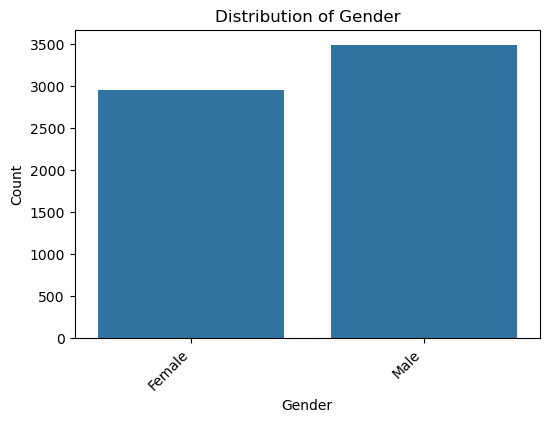

Frequency Distribution for Gender:
________________________________________
        Count  Frequency_Ratio (%)
Gender                            
Male     3493                 54.1
Female   2961                 45.9



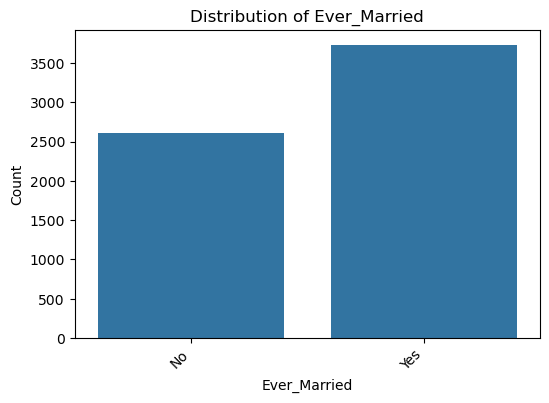

Frequency Distribution for Ever_Married:
________________________________________
              Count  Frequency_Ratio (%)
Ever_Married                            
Yes            3734                 58.9
No             2609                 41.1



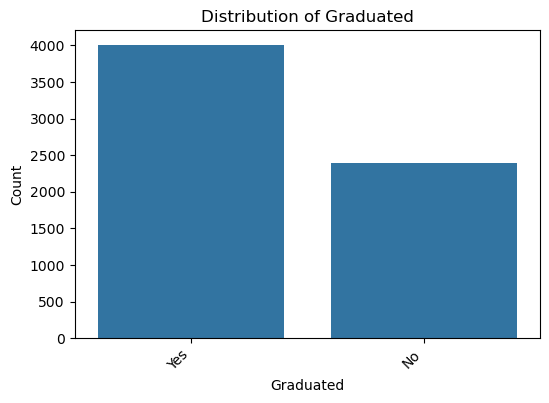

Frequency Distribution for Graduated:
________________________________________
           Count  Frequency_Ratio (%)
Graduated                            
Yes         4007                 62.7
No          2388                 37.3



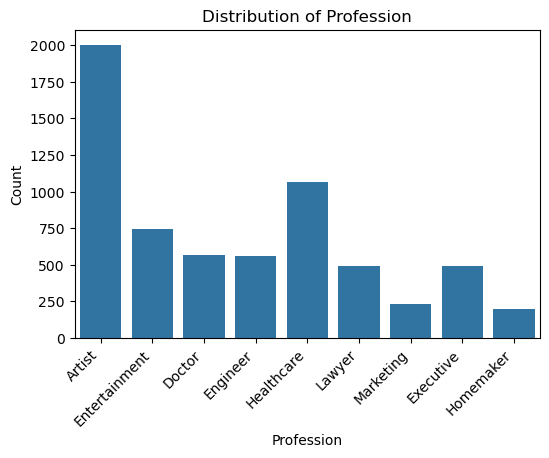

Frequency Distribution for Profession:
________________________________________
               Count  Frequency_Ratio (%)
Profession                               
Artist          2005                 31.6
Healthcare      1064                 16.8
Entertainment    745                 11.7
Doctor           567                  8.9
Engineer         562                  8.9
Lawyer           491                  7.7
Executive        489                  7.7
Marketing        230                  3.6
Homemaker        195                  3.1



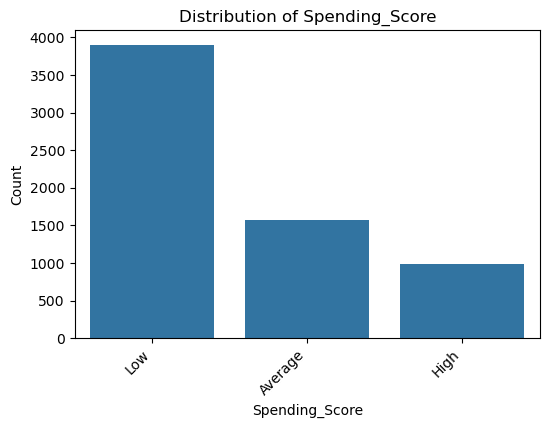

Frequency Distribution for Spending_Score:
________________________________________
                Count  Frequency_Ratio (%)
Spending_Score                            
Low              3900                 60.4
Average          1570                 24.3
High              984                 15.2



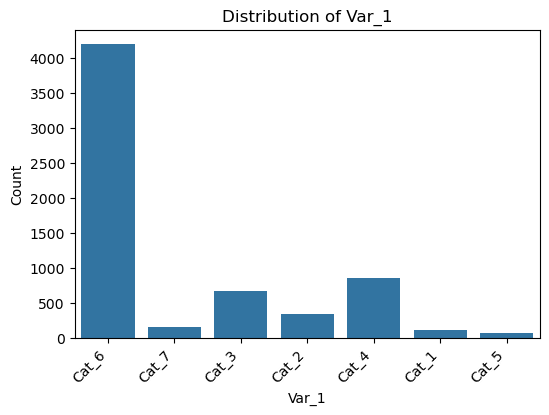

Frequency Distribution for Var_1:
________________________________________
       Count  Frequency_Ratio (%)
Var_1                            
Cat_6   4199                 65.7
Cat_4    852                 13.3
Cat_3    668                 10.4
Cat_2    342                  5.3
Cat_7    160                  2.5
Cat_1    112                  1.8
Cat_5     61                  1.0



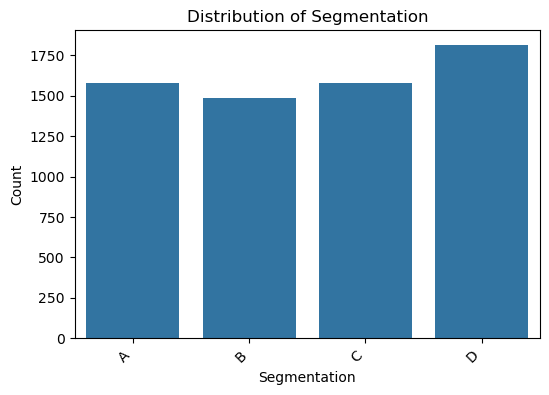

******TARGET******
Frequency Distribution for Segmentation:
________________________________________
              Count  Frequency_Ratio (%)
Segmentation                            
D              1814                 28.1
A              1578                 24.4
C              1576                 24.4
B              1486                 23.0



In [18]:
# nominal EDA

def plot_bar(df, column):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=column, data=df)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Count')
    plt.show()

def check_frequency(df, column):
    frequency = df[column].value_counts()
    frequency_ratios = round(df[column].value_counts(normalize=True) * 100, 1)
    freq_df = pd.DataFrame({
        'Count': frequency,
        'Frequency_Ratio (%)': frequency_ratios
    })
    print(f"Frequency Distribution for {column}:\n{'_'*40}\n{freq_df}\n")



for col in nominal_df.columns:
    plot_bar(nominal_df, col)
    if col == target:
            print("******TARGET******")
    check_frequency(nominal_df, col)
    

In [19]:
# Target class EDA

# drop NaNs
cleaned_df = train_df[ml_attr_dict['ML_attr']].dropna()
feature_df = cleaned_df.iloc[:, :-1].copy()
target_df = cleaned_df[target].copy()

# Dummy encoding
enc_featre_df = pd.get_dummies(feature_df, dtype=int)
encoded_df = pd.concat([enc_featre_df, target_df], axis=1)
encoded_df

Age  Work_Experience  Family_Size  Gender_Female  Gender_Male  \
0      32              9.0          1.0              1            0   
2      33              1.0          4.0              1            0   
3      48              0.0          6.0              1            0   
4      28              9.0          1.0              1            0   
5      45              3.0          3.0              1            0   
...   ...              ...          ...            ...          ...   
6449   27              8.0          1.0              1            0   
6450   37              0.0          2.0              0            1   
6451   27              6.0          6.0              1            0   
6452   26              0.0          2.0              0            1   
6453   37              0.0          3.0              1            0   

      Ever_Married_No  Ever_Married_Yes  Graduated_No  Graduated_Yes  \
0                   1                 0             0              1   
2                   1                 0             0              1   
3                   0                 1             0              1   
4                   0                 1             1              0   
5                   0                 1             0              1   
...               ...               ...           ...            ...   
6449                1                 0             1              0   
6450                1                 0             0              1   
6451                1                 0             1              0   
6452                1                 0             1              0   
6453                1                 0             0              1   

      Profession_Artist  ...  Spending_Score_High  Spending_Score_Low  \
0                     1  ...                    0                   1   
2                     0  ...                    0                   1   
3                     1  ...                    0                   0   
4                     0  ...                    0                   1   
5                     1  ...                    0                   1   
...                 ...  ...                  ...                 ...   
6449                  0  ...                    0                   1   
6450                  0  ...                    0                   1   
6451                  0  ...                    0                   1   
6452                  1  ...                    0                   1   
6453                  0  ...                    0                   1   

      Var_1_Cat_1  Var_1_Cat_2  Var_1_Cat_3  Var_1_Cat_4  Var_1_Cat_5  \
0               0            0            0            0            0   
2               0            0            0            0            0   
3               0            0            0            0            0   
4               0            0            0            0            0   
5               0            0            0            0            0   
...           ...          ...          ...          ...          ...   
6449            0            0            0            0            0   
6450            0            0            0            0            0   
6451            0            0            0            1            0   
6452            0            0            0            0            0   
6453            0            0            0            0            0   

      Var_1_Cat_6  Var_1_Cat_7  Segmentation  
0               1            0             A  
2               1            0             B  
3               1            0             A  
4               0            1             A  
5               1            0             C  
...           ...          ...           ...  
6449            1            0             D  
6450            1            0             D  
6451            0            0             D  
6452            1            0             D  
6453            1

In [20]:
from sklearn.preprocessing import StandardScaler

# Initialize  StandardScaler
scaler = StandardScaler()

# Normalize the class summaries
norm_enc_feature_df = pd.DataFrame(scaler.fit_transform(enc_featre_df), 
                                    columns=enc_featre_df.columns, 
                                    index=enc_featre_df.index)
norm_enc_df = pd.concat([norm_enc_feature_df, target_df], axis=1)
norm_enc_df

Age  Work_Experience  Family_Size  Gender_Female  Gender_Male  \
0    -0.706118         1.847136    -1.199925       1.097211    -1.097211   
2    -0.645585        -0.483658     0.764222       1.097211    -1.097211   
3     0.262417        -0.775008     2.073654       1.097211    -1.097211   
4    -0.948252         1.847136    -1.199925       1.097211    -1.097211   
5     0.080817         0.099040     0.109507       1.097211    -1.097211   
...        ...              ...          ...            ...          ...   
6449 -1.008785         1.555787    -1.199925       1.097211    -1.097211   
6450 -0.403451        -0.775008    -0.545209      -0.911402     0.911402   
6451 -1.008785         0.973088     2.073654       1.097211    -1.097211   
6452 -1.069319        -0.775008    -0.545209      -0.911402     0.911402   
6453 -0.403451        -0.775008     0.109507       1.097211    -1.097211   

      Ever_Married_No  Ever_Married_Yes  Graduated_No  Graduated_Yes  \
0            1.208868         -1.208868     -0.749586       0.749586   
2            1.208868         -1.208868     -0.749586       0.749586   
3           -0.827220          0.827220     -0.749586       0.749586   
4           -0.827220          0.827220      1.334069      -1.334069   
5           -0.827220          0.827220     -0.749586       0.749586   
...               ...               ...           ...            ...   
6449         1.208868         -1.208868      1.334069      -1.334069   
6450         1.208868         -1.208868     -0.749586       0.749586   
6451         1.208868         -1.208868      1.334069      -1.334069   
6452         1.208868         -1.208868      1.334069      -1.334069   
6453         1.208868         -1.208868     -0.749586       0.749586   

      Profession_Artist  ...  Spending_Score_High  Spending_Score_Low  \
0              1.432648  ...            -0.426331            0.817005   
2             -0.698008  ...            -0.426331            0.817005   
3              1.432648  ...            -0.426331           -1.223982   
4             -0.698008  ...            -0.426331            0.817005   
5              1.432648  ...            -0.426331            0.817005   
...                 ...  ...                  ...                 ...   
6449          -0.698008  ...            -0.426331            0.817005   
6450          -0.698008  ...            -0.426331            0.817005   
6451          -0.698008  ...            -0.426331            0.817005   
6452           1.432648  ...            -0.426331            0.817005   
6453          -0.698008  ...            -0.426331            0.817005   

      Var_1_Cat_1  Var_1_Cat_2  Var_1_Cat_3  Var_1_Cat_4  Var_1_Cat_5  \
0       -0.130053    -0.242416    -0.327383    -0.377359    -0.100968   
2       -0.130053    -0.242416    -0.327383    -0.377359    -0.100968   
3       -0.130053    -0.242416    -0.327383    -0.377359    -0.100968   
4       -0.130053    -0.242416    -0.327383    -0.377359    -0.100968   
5       -0.130053    -0.242416    -0.327383    -0.377359    -0.100968   
...           ...          ...          ...          ...          ...   
6449    -0.130053    -0.242416    -0.327383    -0.377359    -0.100968   
6450    -0.130053    -0.242416    -0.327383    -0.377359    -0.100968   
6451    -0.130053    -0.242416    -0.327383     2.649998    -0.100968   
6452    -0.130053    -0.242416    -0.327383    -0.377359    -0.100968   
6453    -0.130053    -0.242416    -0.327383    -0.377359    -0.100968   

      Var_1_Cat_6  Var_1_Cat_7  Segmentation  
0        0.699489    -0.159652             A  
2        0.699489    -0.159652             B  
3        0.699489    -0.159652             A  
4       -1.429615     6.263632             A  
5        0.699489    -0.159652             C  
...           ...          ...           ...  
6449     0.699489    -0.159652             D  
6450     0.699489    -0.159652             D  
6451    -1.429615    -0.159652             D  
6452     

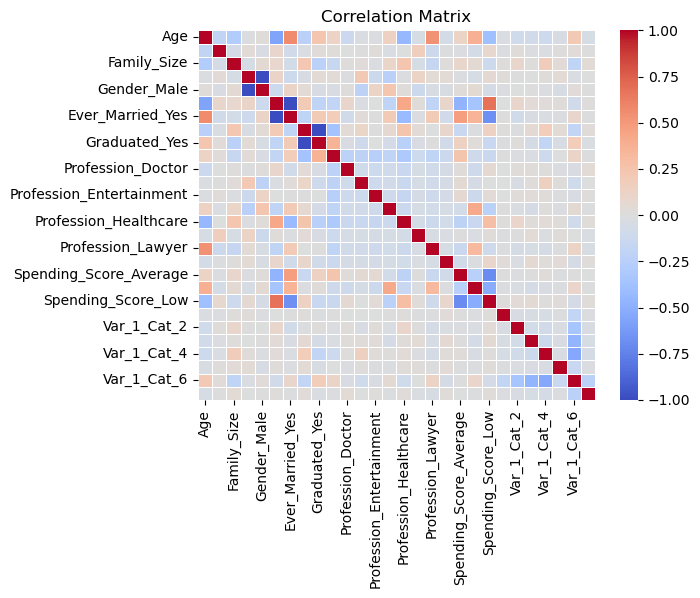

In [21]:
# Correlation
def plot_correlation_matrix(df, annot):
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=annot, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

plot_correlation_matrix(norm_enc_df.iloc[:, :-1], annot=False)

In [22]:
from sklearn.neighbors import KDTree


def get_NN(cap_x):
    '''
    Description: Returns nearest neighbors distances list.

    Parameters:
            cap_x (np.ndarray): design matrix
    Returns:
            nn_dist_list (list): list of nearest neighbors
            
    Documentation:
        https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html

    '''
        
    # build the kdtree
    kdt = KDTree(cap_x)

    nn_dist_list = []
    for i in range(cap_x.shape[0]):
        dist, indices = kdt.query(cap_x[i, :].reshape(1, -1), 2)
        nn_dist_list.append(dist[0, -1])

    return nn_dist_list

def get_hopkins(cap_x):
    '''
    Description: Calculates hopkin's statistic for embedding.

        cap_h = sum(cap_x_nn_dist_list) / (sum(randomly_nn_dist_list) + sum(cap_x_nn_dist_list))

    Parameters:
            cap_x (np.ndarray): design matrix
    Returns:
            cap_h (float): hopkin's statistic value
    '''

    # seed random
    np.random.seed(18)

    # get uniformly randomley distributed data
    data_max = cap_x.max(axis=0)
    data_min = cap_x.min(axis=0)
    random_dist_data = np.random.uniform(low=data_min, high=data_max, size=cap_x.shape)

    ## null hypothesis: get nearest neighbor distance (random data)

    # get list of nearest neighbors for random data
    randomly_nn_dist_list = get_NN(random_dist_data)

    # get nearest neighbor distance from embedding
    cap_x_nn_dist_list = get_NN(cap_x)

    # calculate hopkins
    cap_h = sum(cap_x_nn_dist_list) / (sum(randomly_nn_dist_list) + sum(cap_x_nn_dist_list))

    return cap_h




***** k = 2 and n_components = 2 *****
Hopkin's Statistic for k=2: 0.05
Silhouette Score for k=2: 0.03


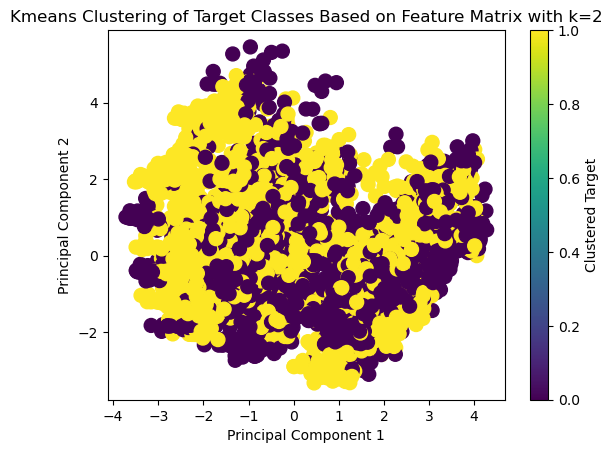

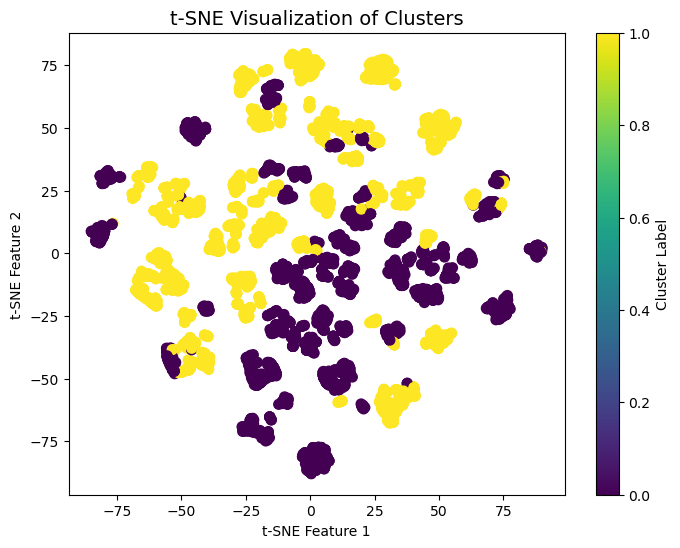


***** k = 2 and n_components = 3 *****
Hopkin's Statistic for k=2: 0.02
Silhouette Score for k=2: 0.05


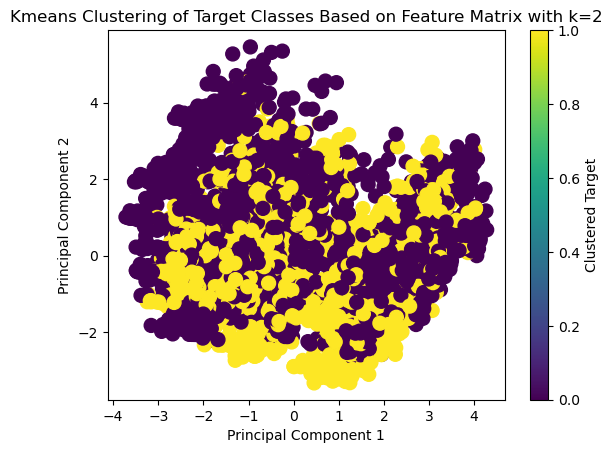

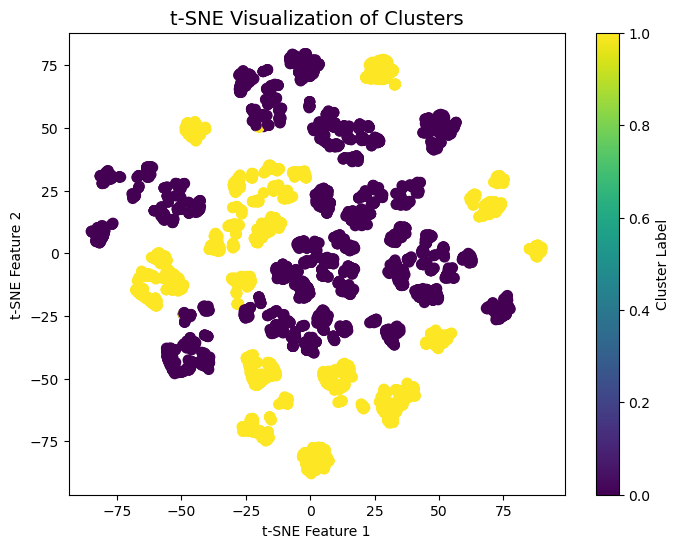


***** k = 2 and n_components = 4 *****
Hopkin's Statistic for k=2: 0.01
Silhouette Score for k=2: 0.06


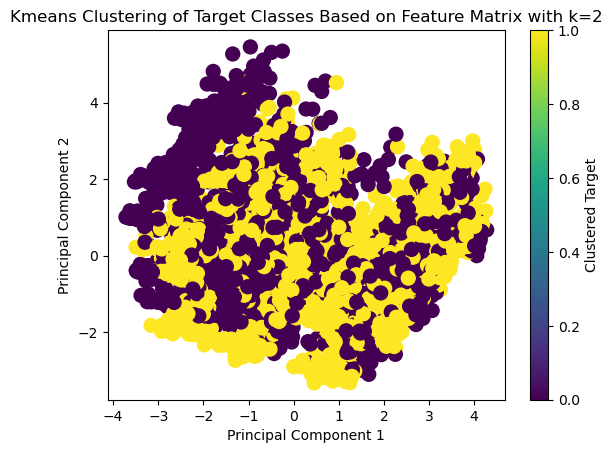

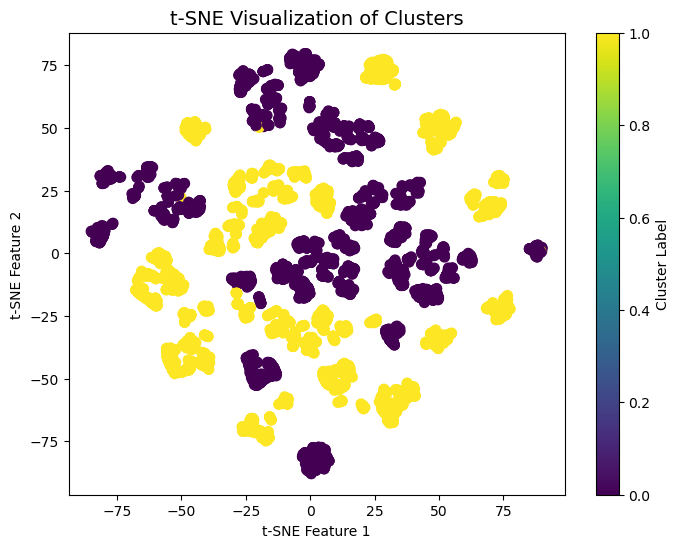


***** k = 2 and n_components = 5 *****
Hopkin's Statistic for k=2: 0.01
Silhouette Score for k=2: 0.05


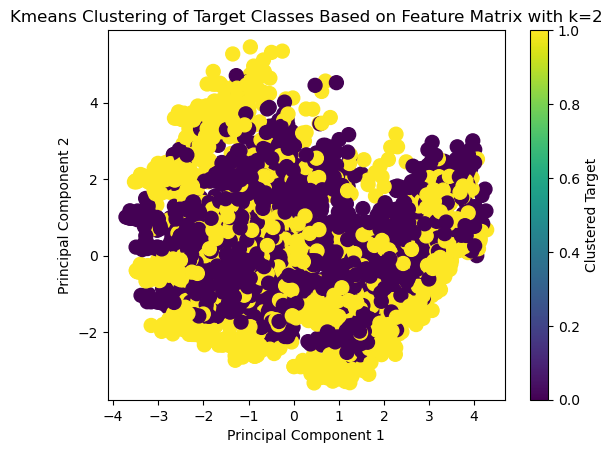

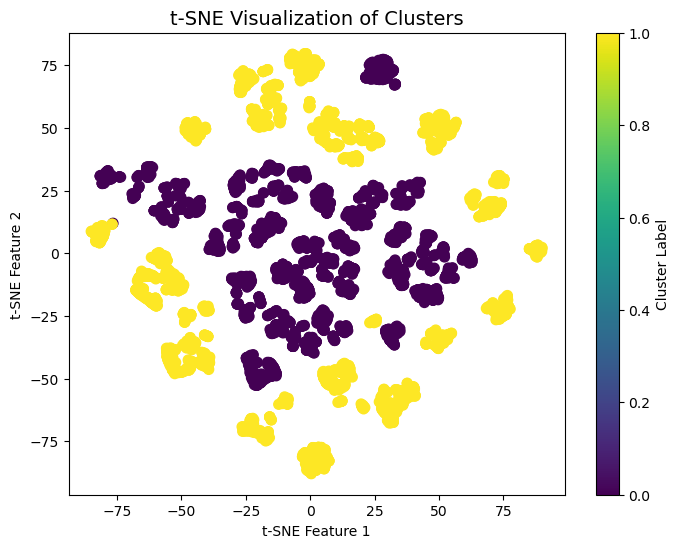


***** k = 2 and n_components = 6 *****
Hopkin's Statistic for k=2: 0.01
Silhouette Score for k=2: 0.05


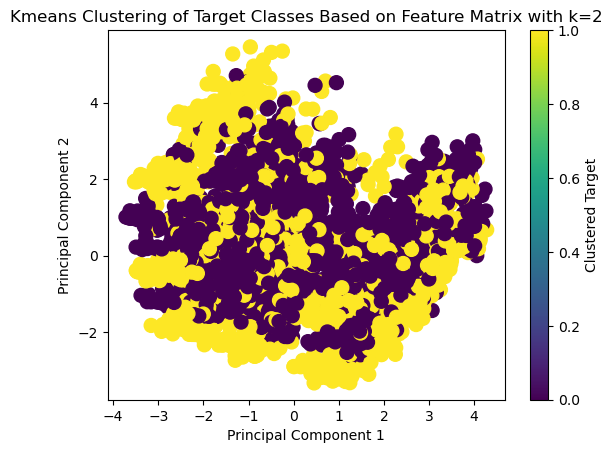

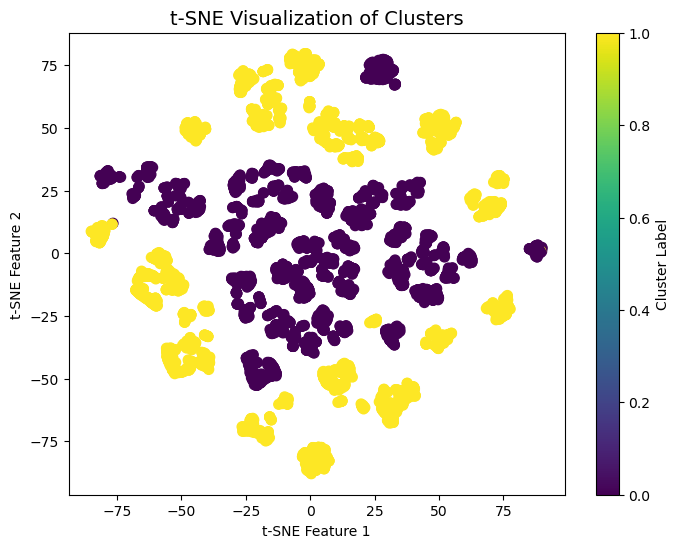


***** k = 2 and n_components = 7 *****
Hopkin's Statistic for k=2: 0.01
Silhouette Score for k=2: 0.05


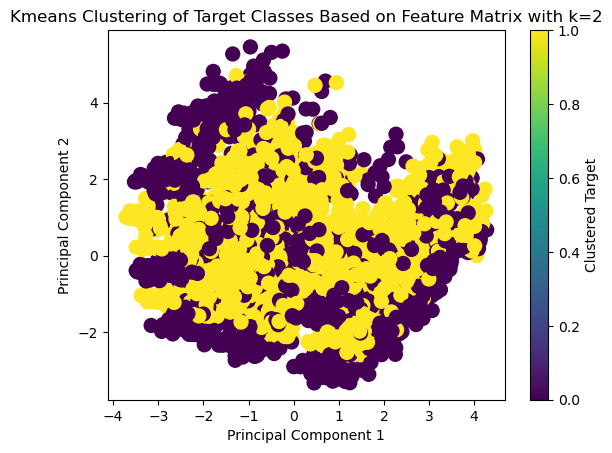

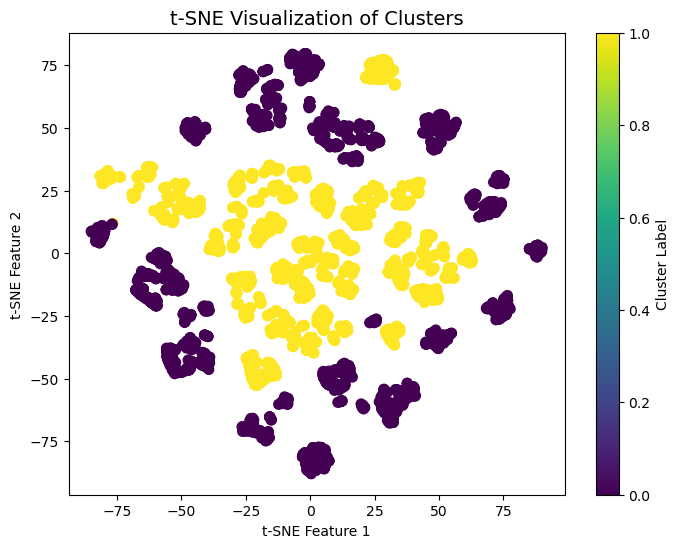


***** k = 3 and n_components = 2 *****
Hopkin's Statistic for k=3: 0.05
Silhouette Score for k=3: 0.03


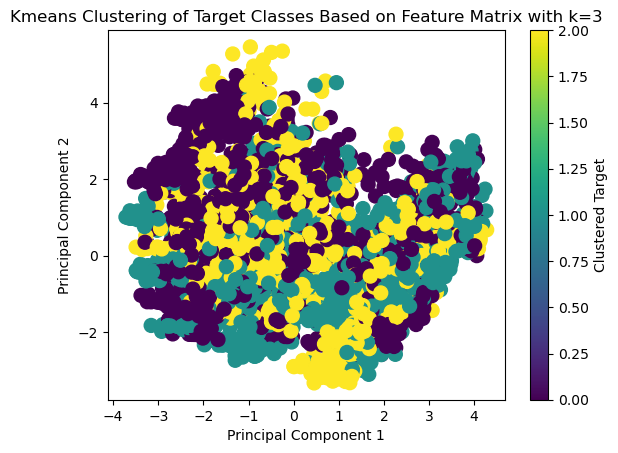

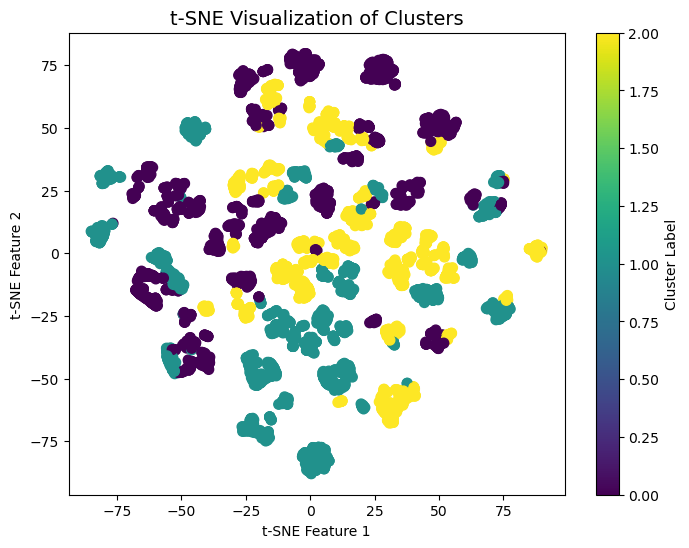


***** k = 3 and n_components = 3 *****
Hopkin's Statistic for k=3: 0.02
Silhouette Score for k=3: 0.04


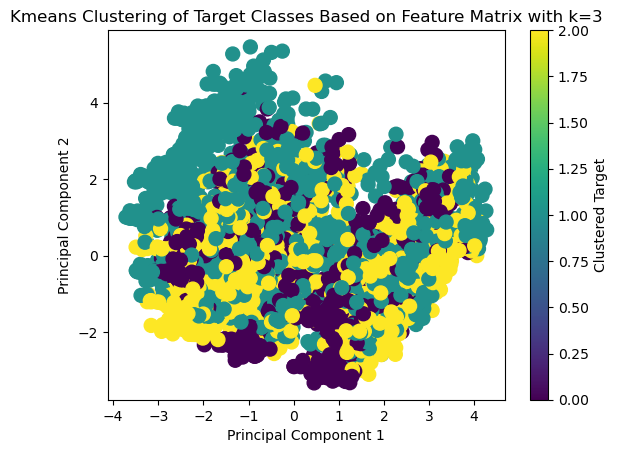

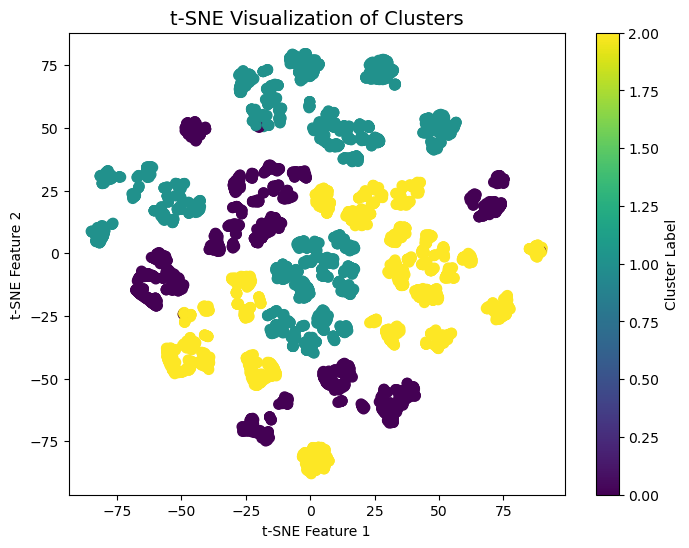


***** k = 3 and n_components = 4 *****
Hopkin's Statistic for k=3: 0.01
Silhouette Score for k=3: 0.05


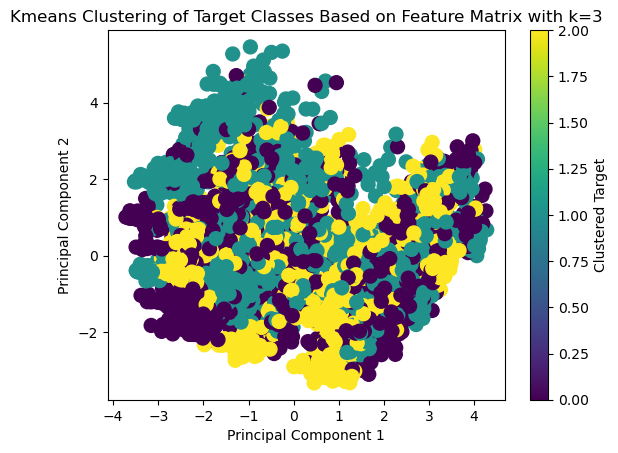

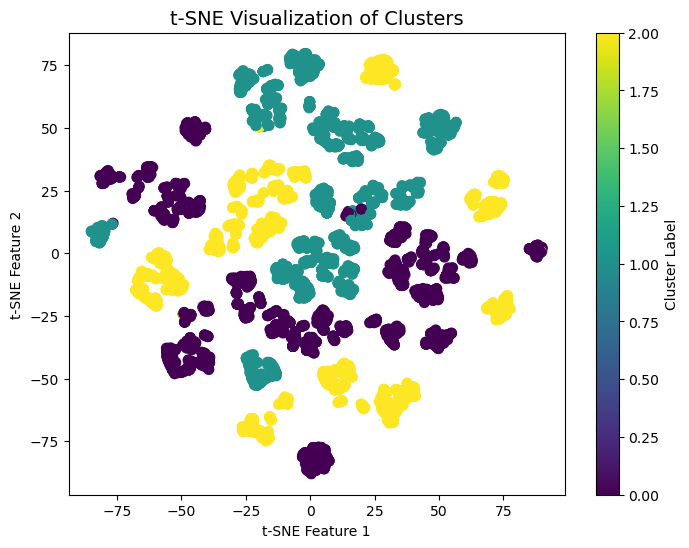


***** k = 3 and n_components = 5 *****
Hopkin's Statistic for k=3: 0.01
Silhouette Score for k=3: 0.06


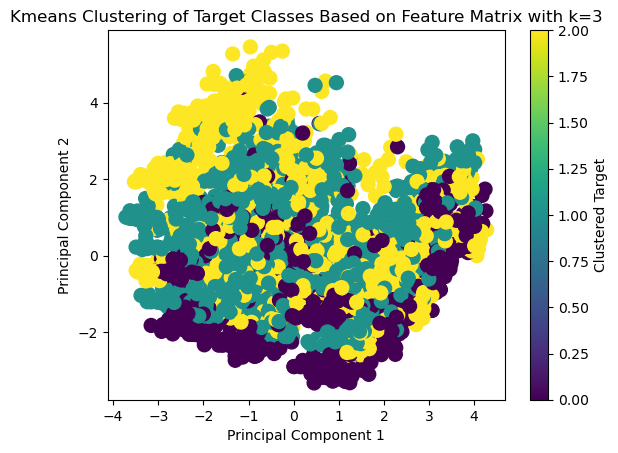

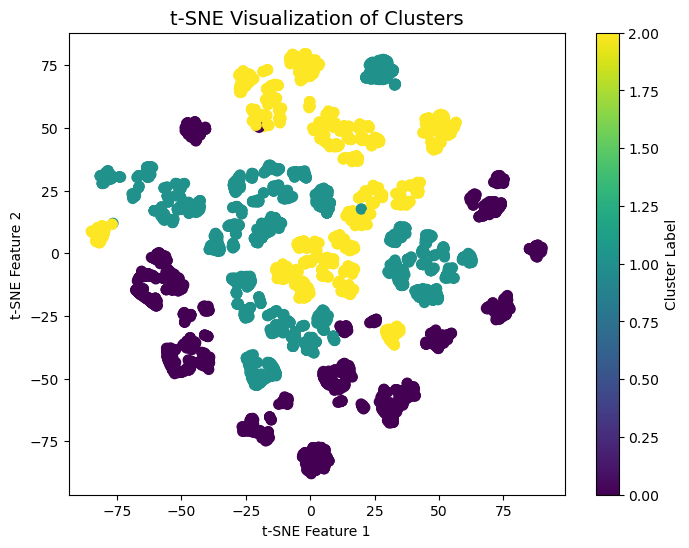


***** k = 3 and n_components = 6 *****
Hopkin's Statistic for k=3: 0.01
Silhouette Score for k=3: 0.06


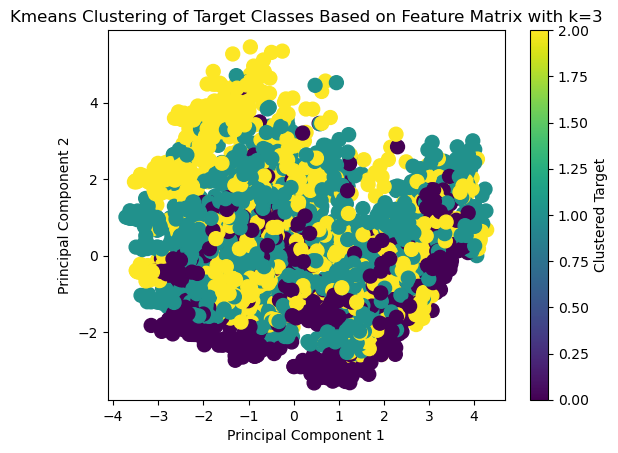

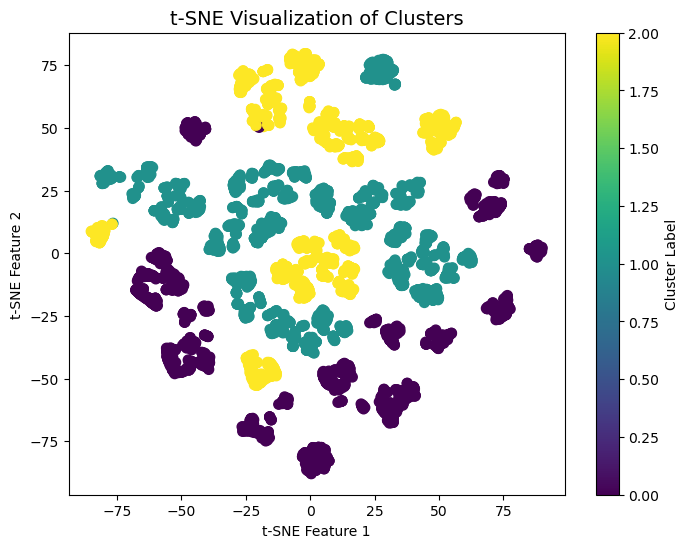


***** k = 3 and n_components = 7 *****
Hopkin's Statistic for k=3: 0.01
Silhouette Score for k=3: 0.07


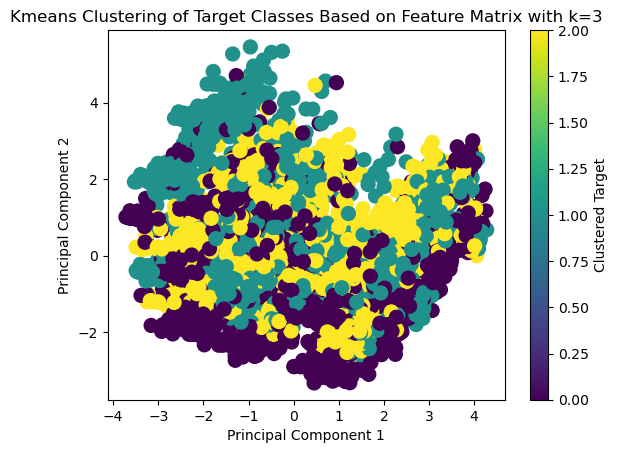

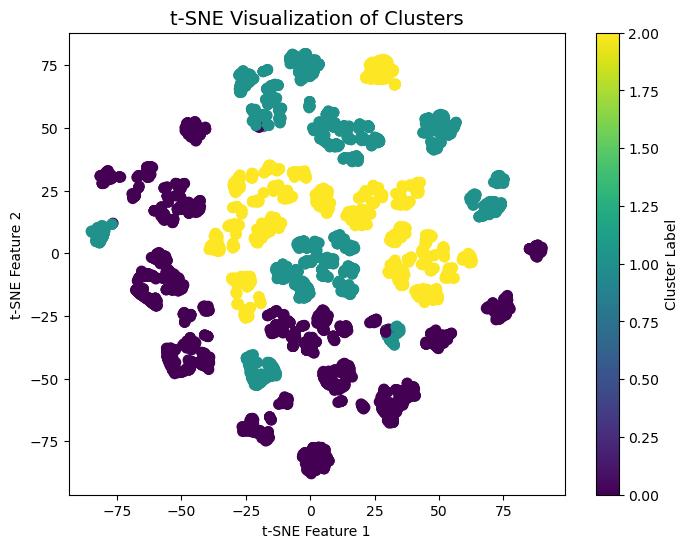


***** k = 4 and n_components = 2 *****
Hopkin's Statistic for k=4: 0.05
Silhouette Score for k=4: 0.03


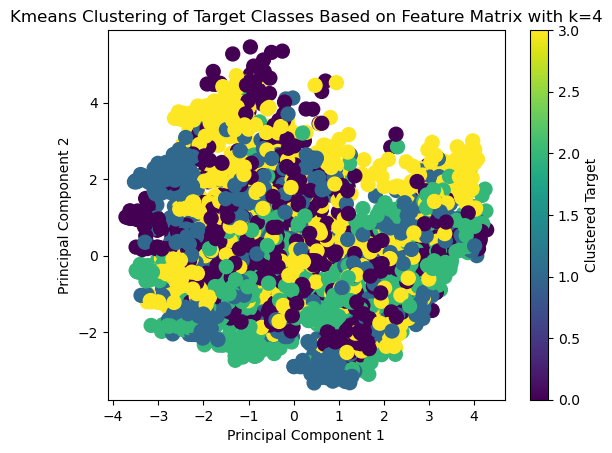

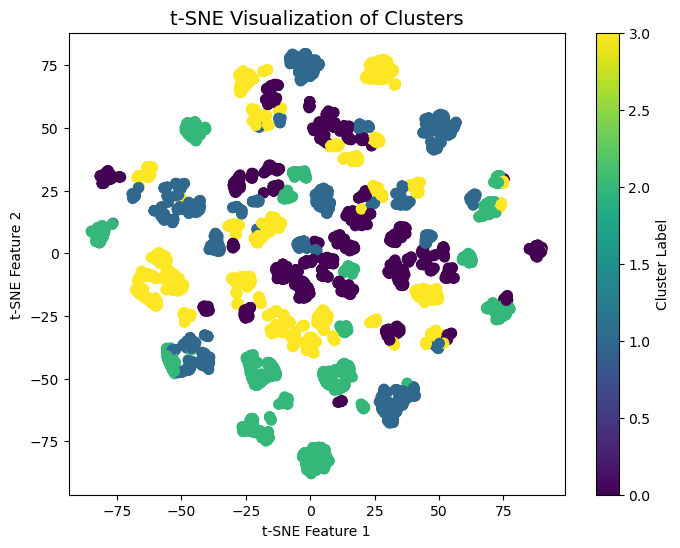


***** k = 4 and n_components = 3 *****
Hopkin's Statistic for k=4: 0.02
Silhouette Score for k=4: 0.07


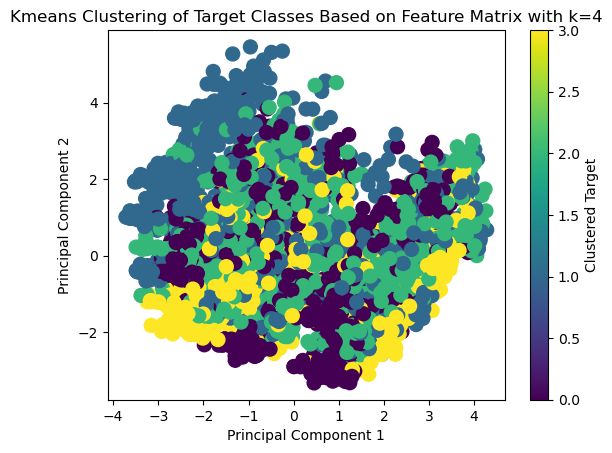

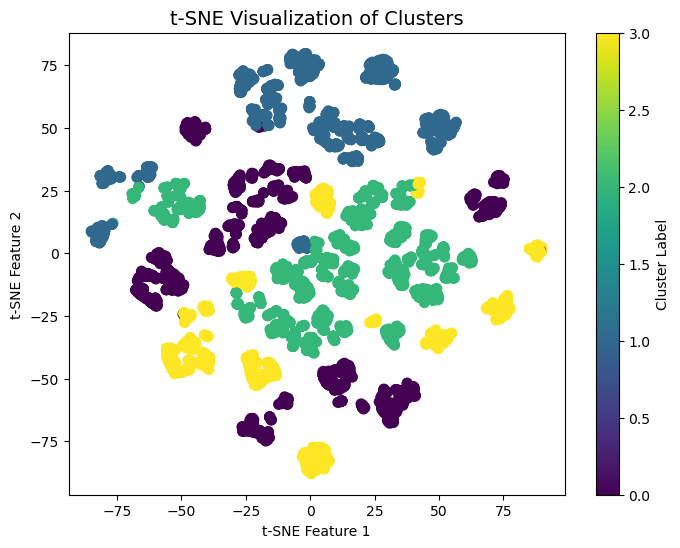


***** k = 4 and n_components = 4 *****
Hopkin's Statistic for k=4: 0.01
Silhouette Score for k=4: 0.02


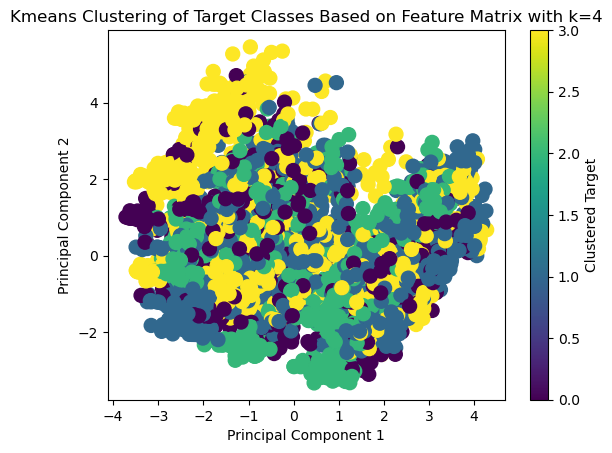

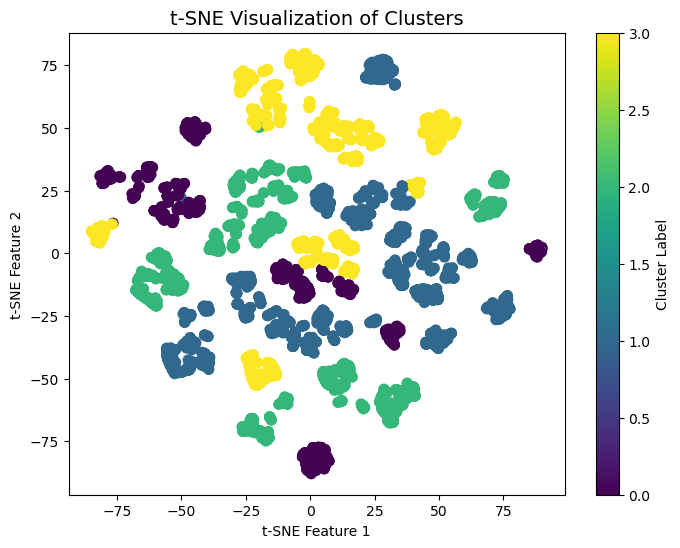


***** k = 4 and n_components = 5 *****
Hopkin's Statistic for k=4: 0.01
Silhouette Score for k=4: 0.03


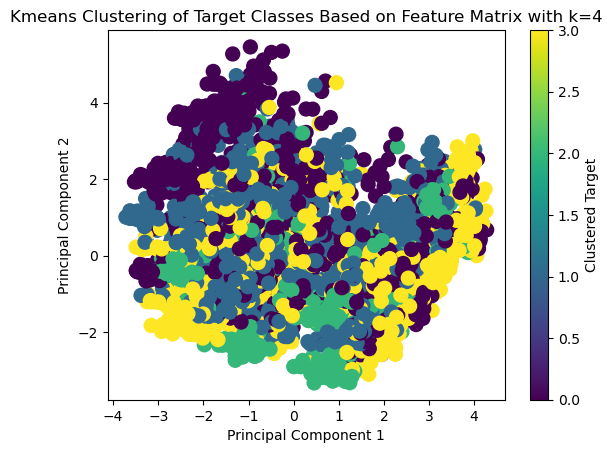

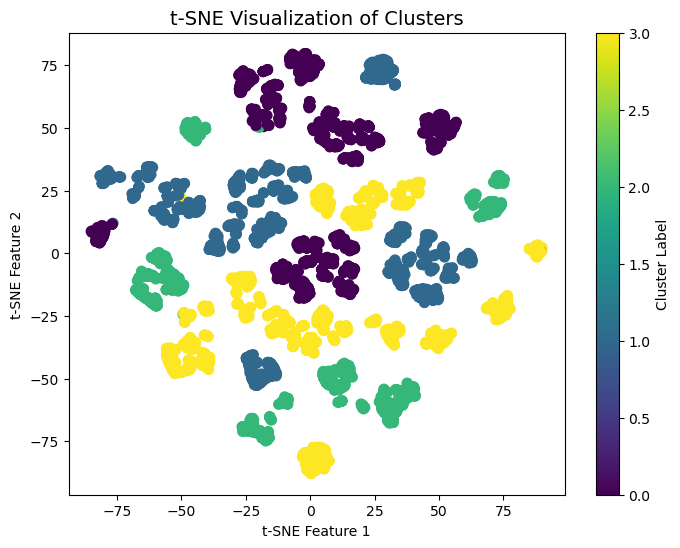


***** k = 4 and n_components = 6 *****
Hopkin's Statistic for k=4: 0.01
Silhouette Score for k=4: 0.06


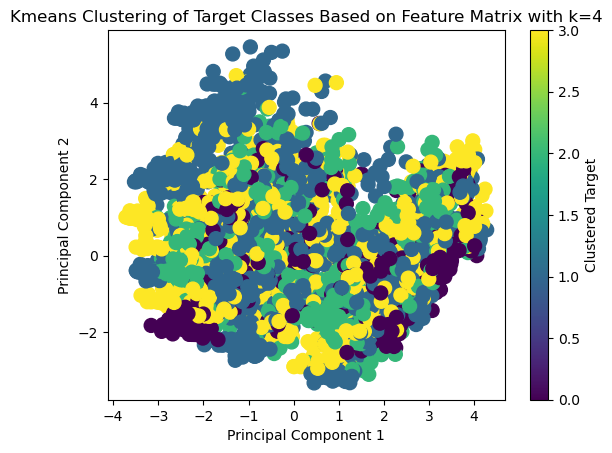

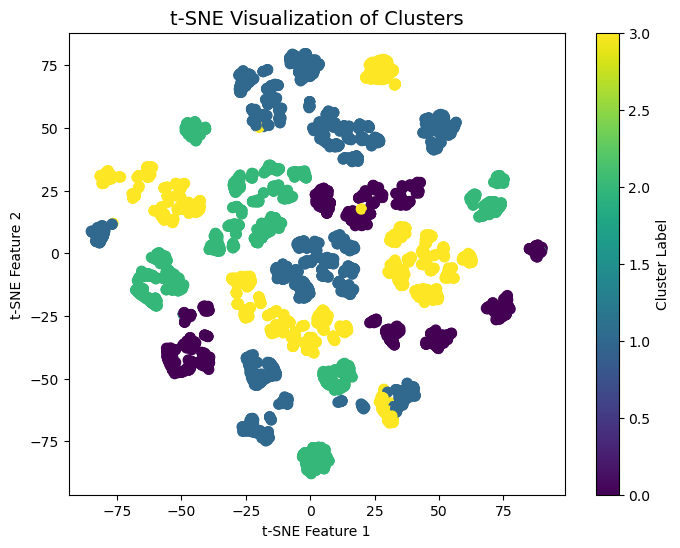


***** k = 4 and n_components = 7 *****
Hopkin's Statistic for k=4: 0.01
Silhouette Score for k=4: 0.07


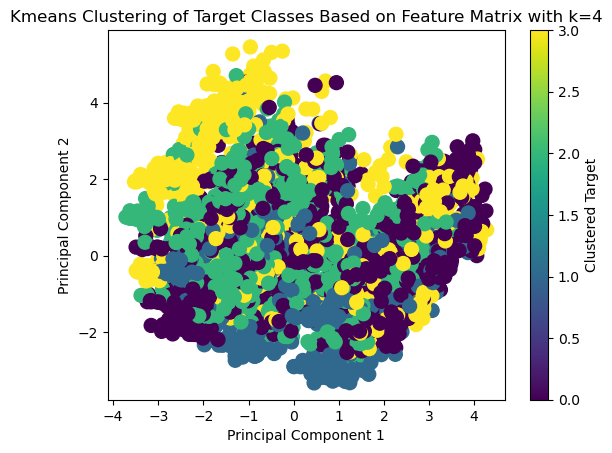

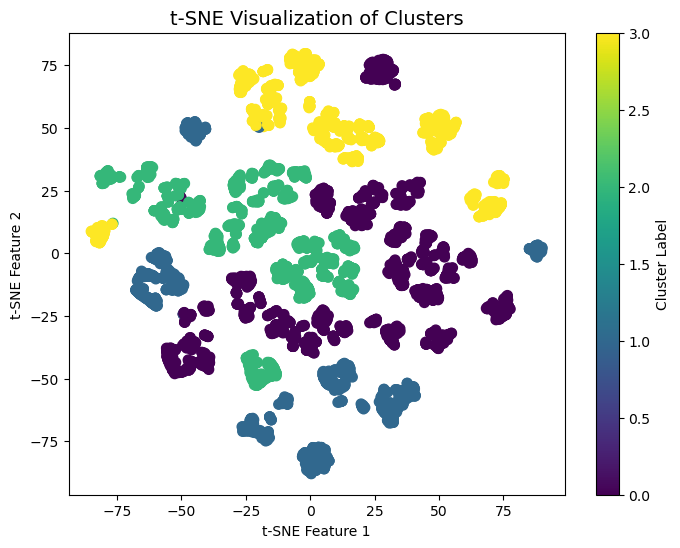

In [24]:
import warnings
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
warnings.filterwarnings("ignore", message="n_jobs value")



for k in range(2, target_df.nunique() + 1):
    for n in range(2, 8):

        print(f"\n***** k = {k} and n_components = {n} *****")

        clustering_df = norm_enc_df.copy()

        # Create a UMAP reducer
        umap_reducer = umap.UMAP(n_neighbors=15, n_components=n, random_state=random_state)

        # Fit and transform the data
        X_umap = umap_reducer.fit_transform(norm_enc_feature_df.to_numpy())

        # Reduce to k for simple classification
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        clustering_df[target] = kmeans.fit_predict(X_umap)
        
        # Get Hopkins
        hopkins = get_hopkins(X_umap)
        print(f"Hopkin's Statistic for k={k}: {hopkins:.2f}")

        # Silhoutte score
        sil_score = silhouette_score(clustering_df.loc[:, :target], clustering_df[target])
        print(f'Silhouette Score for k={k}: {sil_score:.2f}')

        # PCA for plotting
        pca = PCA(n_components=2, random_state=random_state)
        X_pca = pca.fit_transform(clustering_df.iloc[:, :-1])
        

        # Plot the clustered targets
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering_df[target], cmap='viridis', s=100)
        plt.title(f'Kmeans Clustering of Target Classes Based on Feature Matrix with k={k}')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(label='Clustered Target')
        plt.show()

        tsne = TSNE(n_components=2, random_state=random_state)
        X_tsne = tsne.fit_transform(clustering_df.iloc[:, :-1])

        # Step 5: Visualize the clustered data using t-SNE
        plt.figure(figsize=(8, 6))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clustering_df[target], cmap='viridis', s=50)
        plt.colorbar(label='Cluster Label')
        plt.title("t-SNE Visualization of Clusters", fontsize=14)
        plt.xlabel("t-SNE Feature 1")
        plt.ylabel("t-SNE Feature 2")
        plt.show()

        del clustering_df



In [25]:
# get normalized class summaries
norm_class_summary_df = norm_enc_df.groupby(target).mean()

print("Normalized Class Summaries (Z-Score Normalization):")
norm_class_summary_df

Normalized Class Summaries (Z-Score Normalization):


Age  Work_Experience  Family_Size  Gender_Female  \
Segmentation                                                          
A             0.038240         0.082334    -0.242378       0.000766   
B             0.281177        -0.078981    -0.109080       0.047983   
C             0.359921        -0.121217     0.066239       0.030910   
D            -0.634839         0.111815     0.256285      -0.073296   

              Gender_Male  Ever_Married_No  Ever_Married_Yes  Graduated_No  \
Segmentation                                                                 
A               -0.000766         0.027376         -0.027376      0.010279   
B               -0.047983        -0.287299          0.287299     -0.197052   
C               -0.030910        -0.433902          0.433902     -0.393988   
D                0.073296         0.651608         -0.651608      0.548646   

              Graduated_Yes  Profession_Artist  ...  Spending_Score_Average  \
Segmentation                                    ...                           
A                 -0.010279          -0.085526  ...               -0.179910   
B                  0.197052           0.198842  ...                0.145275   
C                  0.393988           0.465575  ...                0.486270   
D                 -0.548646          -0.550339  ...               -0.435754   

              Spending_Score_High  Spending_Score_Low  Var_1_Cat_1  \
Segmentation                                                         
A                       -0.051231            0.195971    -0.004515   
B                        0.140453           -0.231202    -0.017636   
C                        0.193679           -0.570333    -0.005127   
D                       -0.265583            0.578842     0.024784   

              Var_1_Cat_2  Var_1_Cat_3  Var_1_Cat_4  Var_1_Cat_5  Var_1_Cat_6  \
Segmentation                                                                    
A               -0.052086     0.047522     0.099427    -0.009177    -0.073695   
B                0.005266    -0.035653    -0.014656     0.018902     0.027767   
C               -0.014046    -0.081784    -0.236654    -0.042840     0.241817   
D                0.057198     0.067252     0.151465     0.033472    -0.191904   

              Var_1_Cat_7  
Segmentation               
A                0.007314  
B                0.009652  
C               -0.019711  
D                0.003883  

[4 rows x 28 columns]

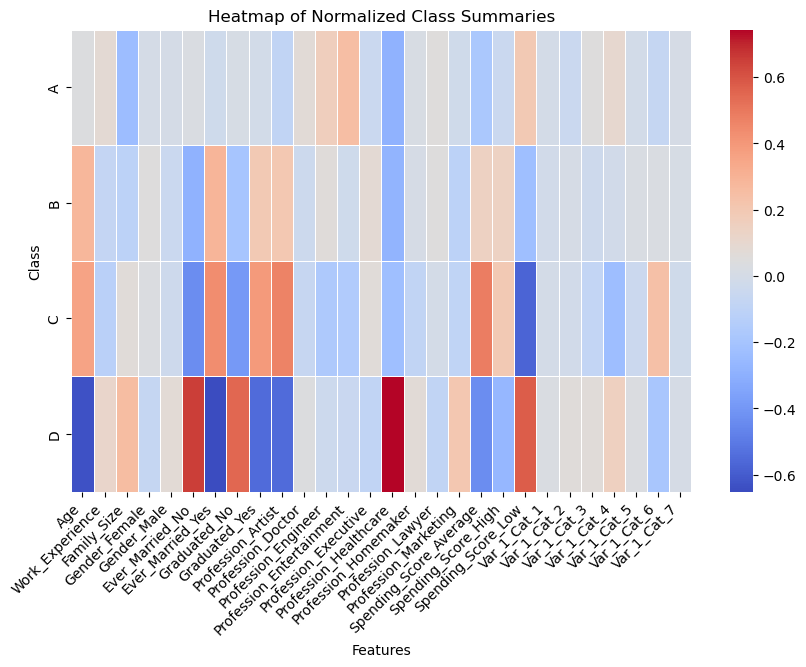

In [26]:
# Plot heatmap of normalized class summaries
plt.figure(figsize=(10, 6))
sns.heatmap(norm_class_summary_df, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Normalized Class Summaries')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Class')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

for k in range(2, target_df.nunique() + 1):

    print(f"\n***** k = {k} *****")

    clustering_df = norm_enc_df.copy()

    # Reduce to k for simple classification
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    class_labels = kmeans.fit_predict(norm_class_summary_df)

    # Create mapping
    target_cluster_map = {old_class: cluster_label for old_class, cluster_label in zip(norm_class_summary_df.index, class_labels)}
    print("\nTarget to Cluster Map:", target_cluster_map)

    # Reassign target labels
    clustering_df[target] = clustering_df[target].map(target_cluster_map)

    # Get Hopkins
    hopkins = get_hopkins(norm_enc_feature_df.to_numpy())
    print(f"Hopkin's Statistic for k={k}: {hopkins:.2f}")

    # Silhoutte score
    sil_score = silhouette_score(clustering_df.loc[:, :target], clustering_df[target])
    print(f'Silhouette Score for k={k}: {sil_score:.2f}')

    # PCA for plotting
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(clustering_df.iloc[:, :-1])

    # Plot the clustered targets
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering_df[target], cmap='viridis', s=100)
    plt.title(f'Kmeans Clustering of Target Classes Based on Feature Summaries with k={k}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Clustered Target')
    plt.show()


    del clustering_df

In [ ]:
# End time
end = time()
elapsed_time = end - start

# Convert elapsed time into hours, minutes, and seconds
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

# Print formatted time
print(f'Script run time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (hh:mm:ss)')

#### Save to html

In [72]:

# Load the notebook
with open('phase2_eda.ipynb') as f:
    notebook = nbformat.read(f, as_version=4)

# Convert the notebook to HTML
html_exporter = HTMLExporter()
html_data, _ = html_exporter.from_notebook_node(notebook)

# Path to the directory you want to create
dir_path = "htmls/"

# Check if the directory exists and create it if it doesn't
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    print(f"Directory '{dir_path}' created.")

# Write the output to an HTML file
with open(dir_path + 'phase2_eda.html', 'w') as f:
    f.write(html_data)